In [128]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from joblib import dump, load

from data_engineering import read_data, get_filter_duplicates_query

### Чтение данных

In [2]:
DATA_PATH = '/home/ataleckij/Projects/university/MO_4sem/laba1-3/data/'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'notMNIST_large/')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'notMNIST_small/')

In [3]:
work_features_matrix, work_labels = read_data(TRAIN_DATA_PATH)
test_features_matrix, test_labels = read_data(TEST_DATA_PATH)

print(work_features_matrix.shape, test_features_matrix.shape)
print(work_labels.shape, test_labels.shape)

D: 100%|██████████| 52912/52912 [00:10<00:00, 5192.82it/s]


error: total=5, percent=9.449759409125443e-06


D: 100%|██████████| 1873/1873 [00:00<00:00, 5261.58it/s]

error: total=2, percent=0.00010681478316599017
(529114, 28, 28) (18724, 28, 28)
(529114,) (18724,)


In [4]:
print(pd.Series(work_labels).value_counts())
print(pd.Series(test_labels).value_counts())

E    52912
C    52912
G    52912
I    52912
H    52912
F    52912
B    52911
J    52911
D    52911
A    52909
dtype: int64
E    1873
B    1873
D    1873
C    1873
J    1872
H    1872
F    1872
G    1872
I    1872
A    1872
dtype: int64


In [5]:
def plt_few_random_images(features_matrix, labels, count=4):
    for _ in range(count):
        i = np.random.randint(features_matrix.shape[0])
        print(labels[i])
        plt.imshow(features_matrix[i])
        plt.show()

TRAIN IMAGES SAMPLES
I


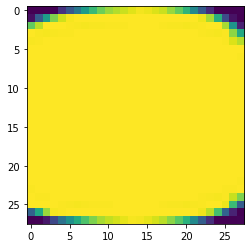

C


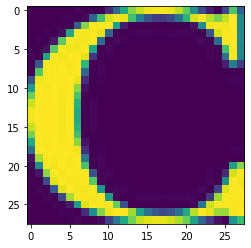

D


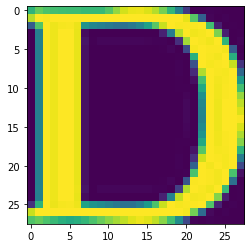

I


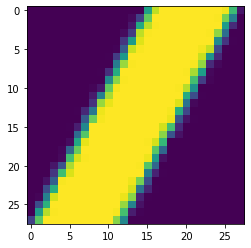

TEST IMAGES SAMPLES
H


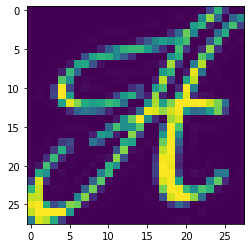

A


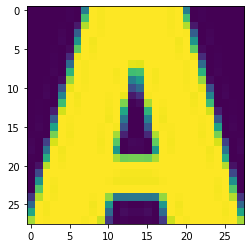

H


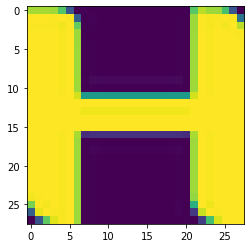

F


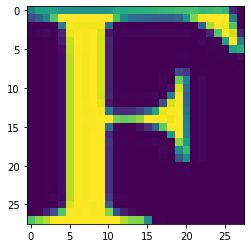

In [6]:
print('TRAIN IMAGES SAMPLES')
plt_few_random_images(work_features_matrix, work_labels)
print('TEST IMAGES SAMPLES')
plt_few_random_images(test_features_matrix, test_labels)

### Удаление дубликатов данных

#### Фильтрация хешами

In [7]:
filter_query = get_filter_duplicates_query(work_features_matrix)
filter_query.shape

100%|██████████| 529114/529114 [00:04<00:00, 106279.24it/s]


(461946,)

In [8]:
work_features_matrix = work_features_matrix[filter_query]
work_labels = work_labels[filter_query]

In [9]:
filter_query = get_filter_duplicates_query(work_features_matrix, test_features_matrix)
filter_query.shape

100%|██████████| 461946/461946 [00:04<00:00, 110398.82it/s]


(457363,)

In [10]:
work_features_matrix = work_features_matrix[filter_query]
work_labels = work_labels[filter_query]

#### Фильтрация расстояниями

### Разделение данных

In [118]:
train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
                                              test_size=0.50, stratify=work_labels, random_state=42)

print(train_indixes.shape, val_indexes.shape)

(228681,) (228682,)


In [119]:
train_features_matrix, train_labels = work_features_matrix[train_indixes], work_labels[train_indixes]
val_features_matrix, val_labels = work_features_matrix[val_indexes], work_labels[val_indexes]

### Обучение простого классификатора

In [120]:
def flatten(features_matrix):
    flatten_shape = (features_matrix.shape[0], np.prod(features_matrix.shape[1:]))
    return features_matrix.reshape(flatten_shape)

In [121]:
# work_features = flatten(work_features_matrix)
train_features = flatten(train_features_matrix)
val_features = flatten(val_features_matrix)
test_features = flatten(test_features_matrix)

In [123]:
pca = PCA(n_components=50)

In [124]:
train_features = pca.fit_transform(train_features/255)
val_features = pca.transform(val_features/255)
test_features = pca.transform(test_features/255)

In [122]:
clf = SVC(C=15, random_state=42, kernel='rbf')  # , max_iter=100
clf

SVC(C=15, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [125]:
clf.fit(train_features, train_labels)

SVC(C=15, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [126]:
clf.score(val_features[:50000], val_labels[:50000])

0.90706

#### контрольное тест

In [127]:
clf.score(test_features, test_labels)

0.9626148258919034

если увеличить n_components или train_size можно ещё увеличить качество

In [129]:
dump(clf, 'svm_0.9626')
dump(pca, 'pca_0.9626')

# clf = load('svm_0.9626')
# pca = load('pca_0.9626')

['pca_0.9626']

Кривые обучения 50, 100, 1000, 50000

In [112]:
def get_learning_curves():
    train_values_counts, train_scores, val_scores = [], [], []
    for test_size in tqdm([0.99989, 0.99978, 0.9978, 0.8906]):  # 50, 100, 1000, 50000
        train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
                                                  test_size=test_size, stratify=work_labels, random_state=42)
        train_features_matrix, train_labels = work_features_matrix[train_indixes], work_labels[train_indixes]
        val_features_matrix, val_labels = work_features_matrix[val_indexes], work_labels[val_indexes]
        train_features = flatten(train_features_matrix)
        val_features = flatten(val_features_matrix)
        train_features = pca.fit_transform(train_features/255)
        val_features = pca.transform(val_features/255)
        clf.fit(train_features, train_labels)
        train_values_counts.append(train_features.shape[0])
        train_scores.append(clf.score(train_features, train_labels))
        val_scores.append(clf.score(val_features[:50000], val_labels[:50000]))
    return train_values_counts, train_scores, val_scores

train_values_counts, train_scores, val_scores = get_learning_curves()

100%|██████████| 4/4 [03:26<00:00, 51.71s/it]


[50, 100, 1006, 50035]


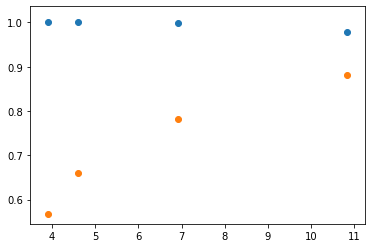

In [116]:
print(train_values_counts)
plt.scatter(np.log(train_values_counts), train_scores)
plt.scatter(np.log(train_values_counts), val_scores)
plt.show()

### Нейронные сети